# 3. Model Evaluation

In [1]:
import sys
sys.path.insert(0, '..')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from dill import dump, load
from joblib import parallel_config
from tqdm.auto import tqdm

from scjdsurv.evaluate import evaluate_ensemble
from scjdsurv.model import (CoxLASSOEnsemble, CoxPHEnsemble, load_parameters,
                            sCJDSurvEnsemble)

Import data

In [2]:
# Import imputed training data
with open('mice/imputed_train', 'rb') as file:
    imputed_train = load(file)
    
# Import imputed test data
with open('mice/imputed_test', 'rb') as file:
    imputed_test = load(file)

## 3.1 Multiple NMTLR Models

In [3]:
models_to_evaluate = [
    '2 layers MLP, ReLU, BatchNorm, Dropout',
    '3 layers MLP, ReLU, BatchNorm, Dropout',
    '4 layers MLP, ReLU, BatchNorm, Dropout',
    '5 layers MLP, ReLU, BatchNorm, Dropout',
]

multi_evaluation = []

for model_name in tqdm(models_to_evaluate):
    
    ensemble_parameters = load_parameters(f'./parameters/{model_name}.json')
    
    with parallel_config(backend='loky', inner_max_num_threads=1):
        ensemble = sCJDSurvEnsemble(model_name)
        ensemble.fit(
            imputed_train,
            ensemble_parameters,
            n_jobs=10,
            progress_bar=False
        )
    
    result = ensemble.predict_surv_df(imputed_test=imputed_test)
    evaluation = evaluate_ensemble(result, imputed_train, imputed_test, print_results=False)
    multi_evaluation.append(evaluation)

  0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
evaluation_dict = {}

for i, evaluation in enumerate(multi_evaluation):
    evaluation_dict.update(
        {
            models_to_evaluate[i]: {
                'c_index': evaluation['c_index'],
                'ibs': evaluation['ibs'],
                'auc_5': evaluation['auc_5'],
                'auc_10': evaluation['auc_10'],
            }
        }
    )

pd.DataFrame.from_dict(evaluation_dict, orient='index')

c_index       ibs     auc_5    auc_10
2 layers MLP, ReLU, BatchNorm, Dropout  0.732578  0.084311  0.857843  0.860919
3 layers MLP, ReLU, BatchNorm, Dropout  0.732035  0.078673  0.866387  0.872355
4 layers MLP, ReLU, BatchNorm, Dropout  0.731398  0.091537  0.852381  0.871452
5 layers MLP, ReLU, BatchNorm, Dropout  0.733050  0.081766  0.866363  0.870806

## 3.2 Cox Models

In [5]:
# CoxPH Model
ensemble = CoxPHEnsemble()
ensemble.fit(imputed_train, n_jobs=10, progress_bar=False)
result = ensemble.predict_surv_df(imputed_test=imputed_test)
coxph = evaluate_ensemble(result, imputed_train, imputed_test, print_results=True)

Concordance index       0.73
Integrated Brier score  0.083
AUC at 5 months         0.852
AUC at 10 months        0.863


In [6]:
# CoxPH with LASSO penalty. For tuning see Appendix 2.
ensemble = CoxLASSOEnsemble()
ensemble.fit(imputed_train, alpha=0.006, n_jobs=10, progress_bar=False)
result = ensemble.predict_surv_df(imputed_test=imputed_test)
coxlasso = evaluate_ensemble(result, imputed_train, imputed_test, print_results=True)

Concordance index       0.734
Integrated Brier score  0.082
AUC at 5 months         0.857
AUC at 10 months        0.859


## 3.3 Train and Pickle
Train the chosen model, and pickle for the inference step

In [7]:
# Train and evaluate chosen model
model_name = '3 layers MLP, ReLU, BatchNorm, Dropout'

ensemble_parameters = load_parameters(f'./parameters/{model_name}.json')
    
with parallel_config(backend='loky', inner_max_num_threads=1):
    ensemble = sCJDSurvEnsemble(model_name)
    ensemble.fit(
        imputed_train,
        ensemble_parameters,
        n_jobs=10,
        progress_bar=False
    )

result = ensemble.predict_surv_df(imputed_test=imputed_test)
nmtlr = evaluate_ensemble(result, imputed_train, imputed_test, print_results=True)

Concordance index       0.732
Integrated Brier score  0.079
AUC at 5 months         0.866
AUC at 10 months        0.872


In [8]:
# Pickle for the inference step
with open('../sCJDSurvEnsemble.model', 'wb') as file:
    dump(ensemble, file)

## 3.4 Visualise Time-dependent Metrics

### Time-dependent Brier Score

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

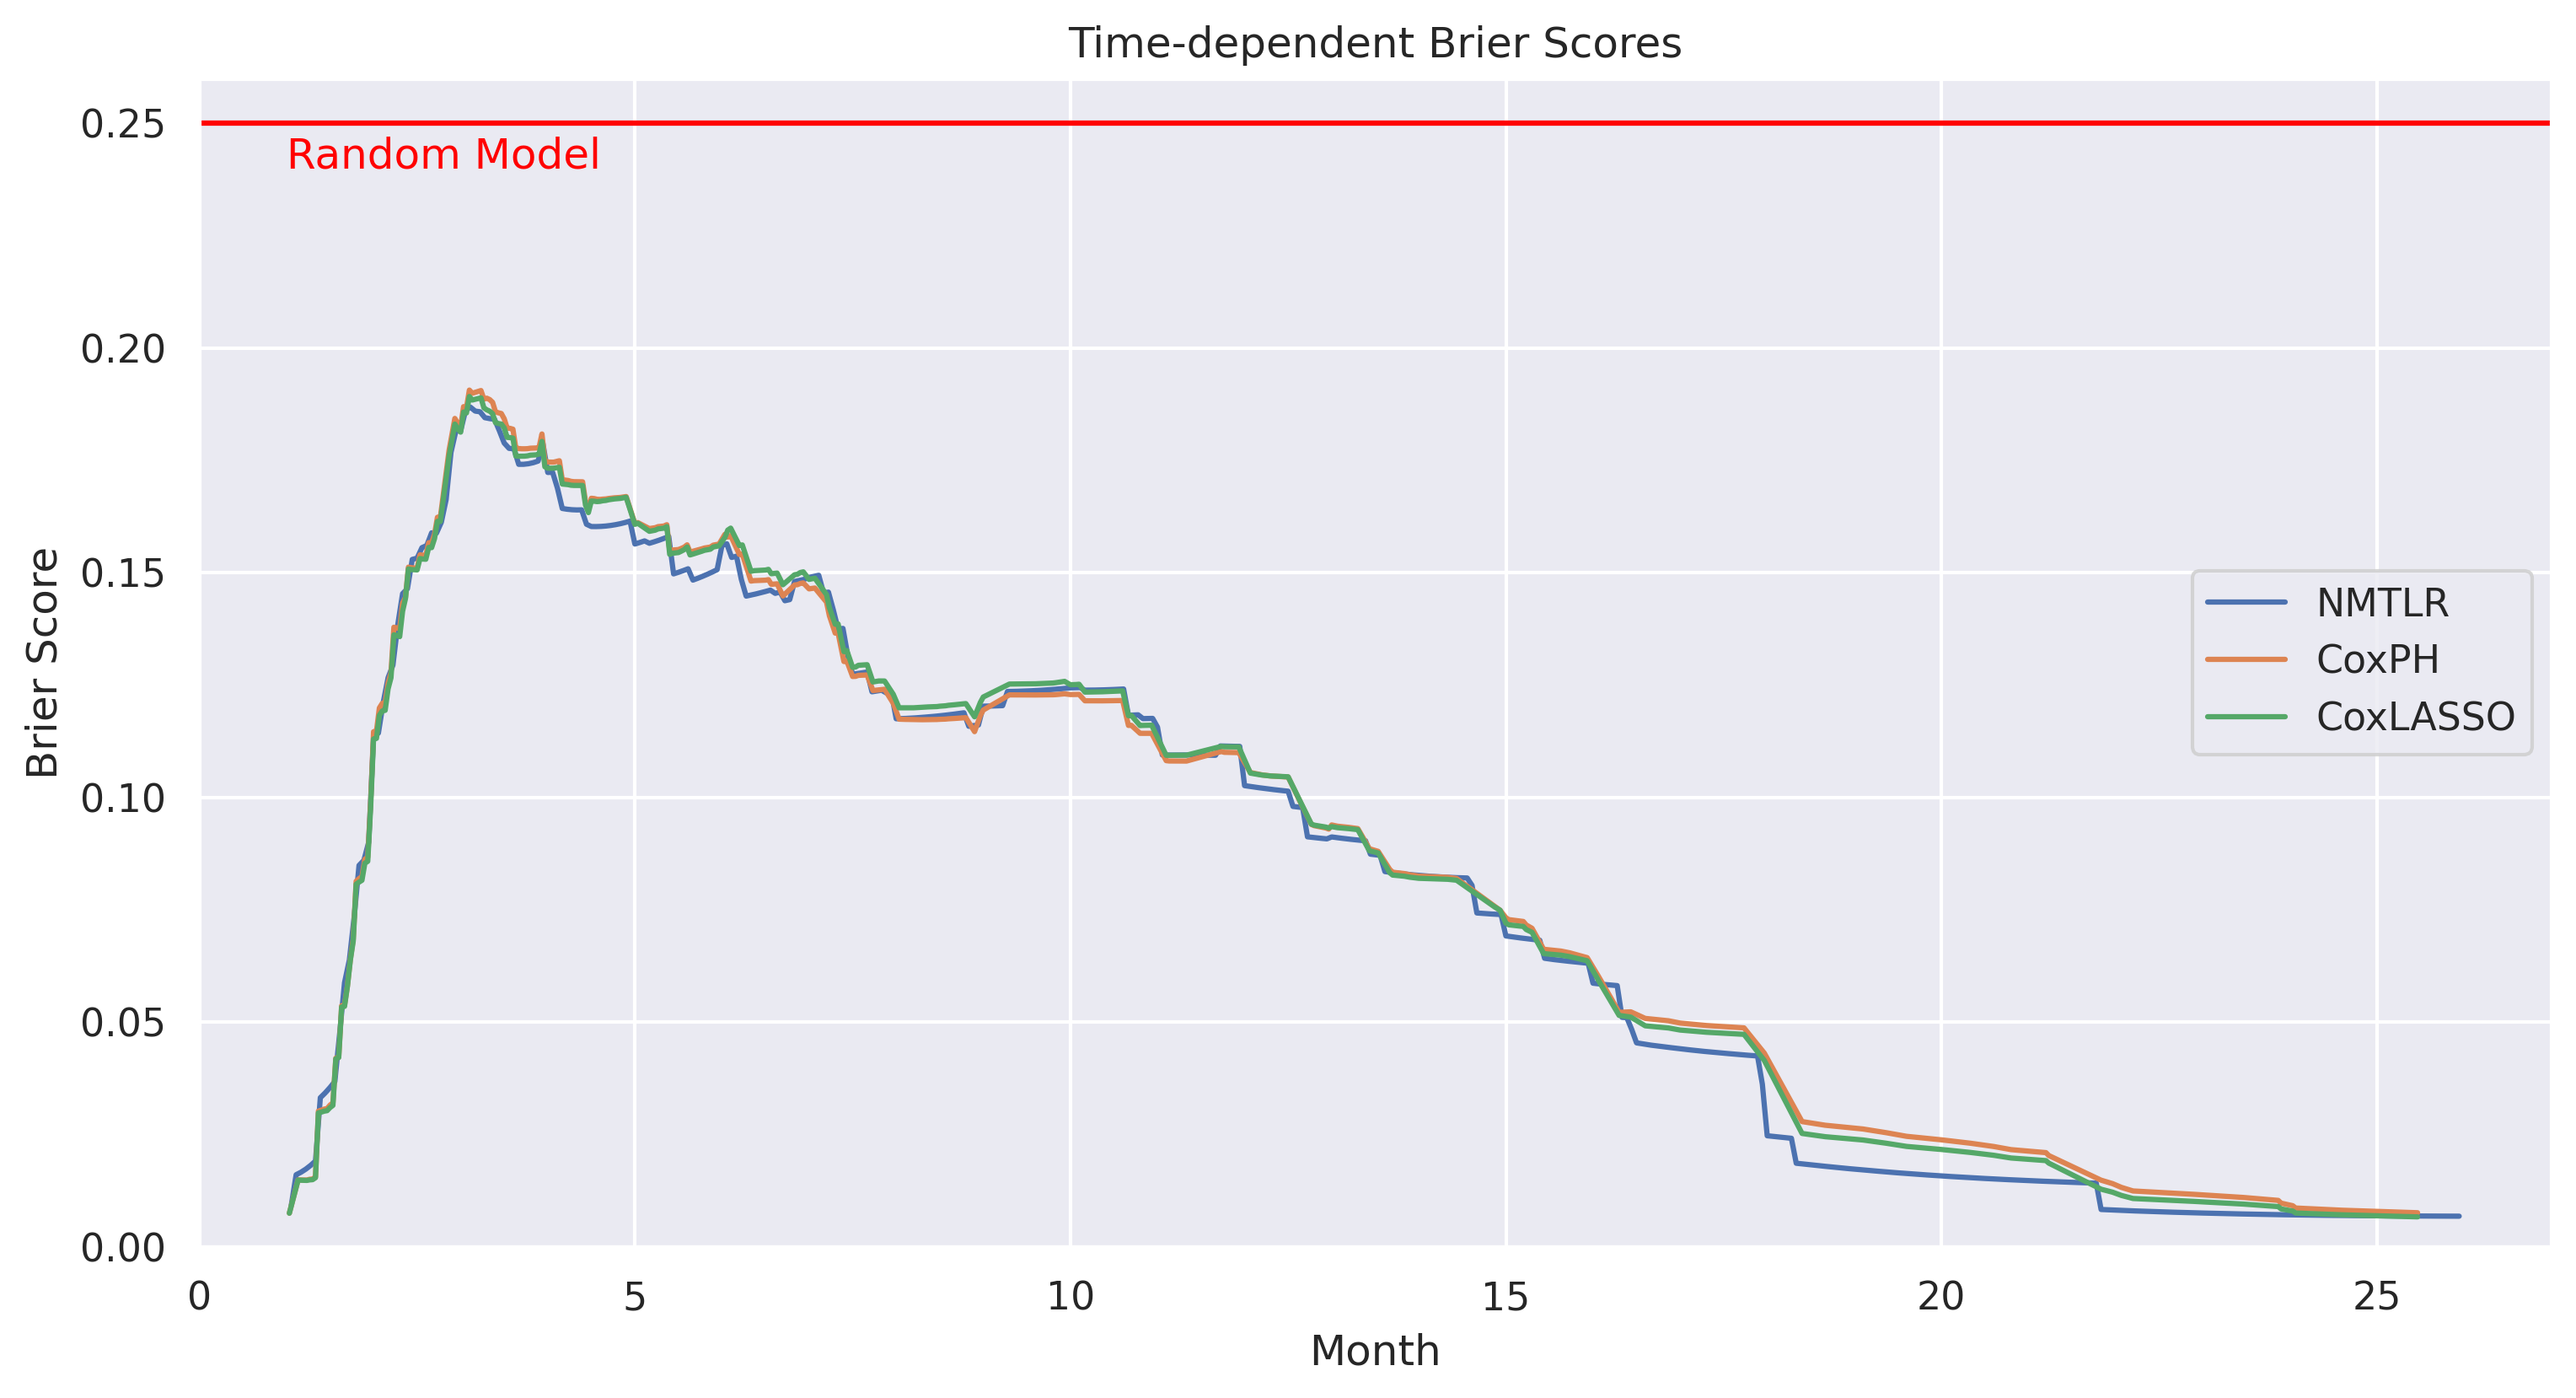

In [9]:
brier_df = pd.DataFrame([nmtlr['brier_df'], coxph['brier_df'], coxlasso['brier_df']], index=['NMTLR', 'CoxPH', 'CoxLASSO']).T

plt.figure(figsize=(12,6), dpi=300)
sns.set_theme(style='darkgrid', font='Arial')

fig = sns.lineplot(
    brier_df,
    dashes=False
)
fig.set(
    ylabel='Brier Score',
    xlabel='Month',
    title='Time-dependent Brier Scores'
)
fig.set_ylim(0,0.26)
fig.set_xlim(0,27)
fig.hlines(0.25, 0, 27, color='red')
fig.text(1, 0.24, 'Random Model', color='red')
sns.move_legend(fig, 'center right')

### Time-dependent AUC Scores

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

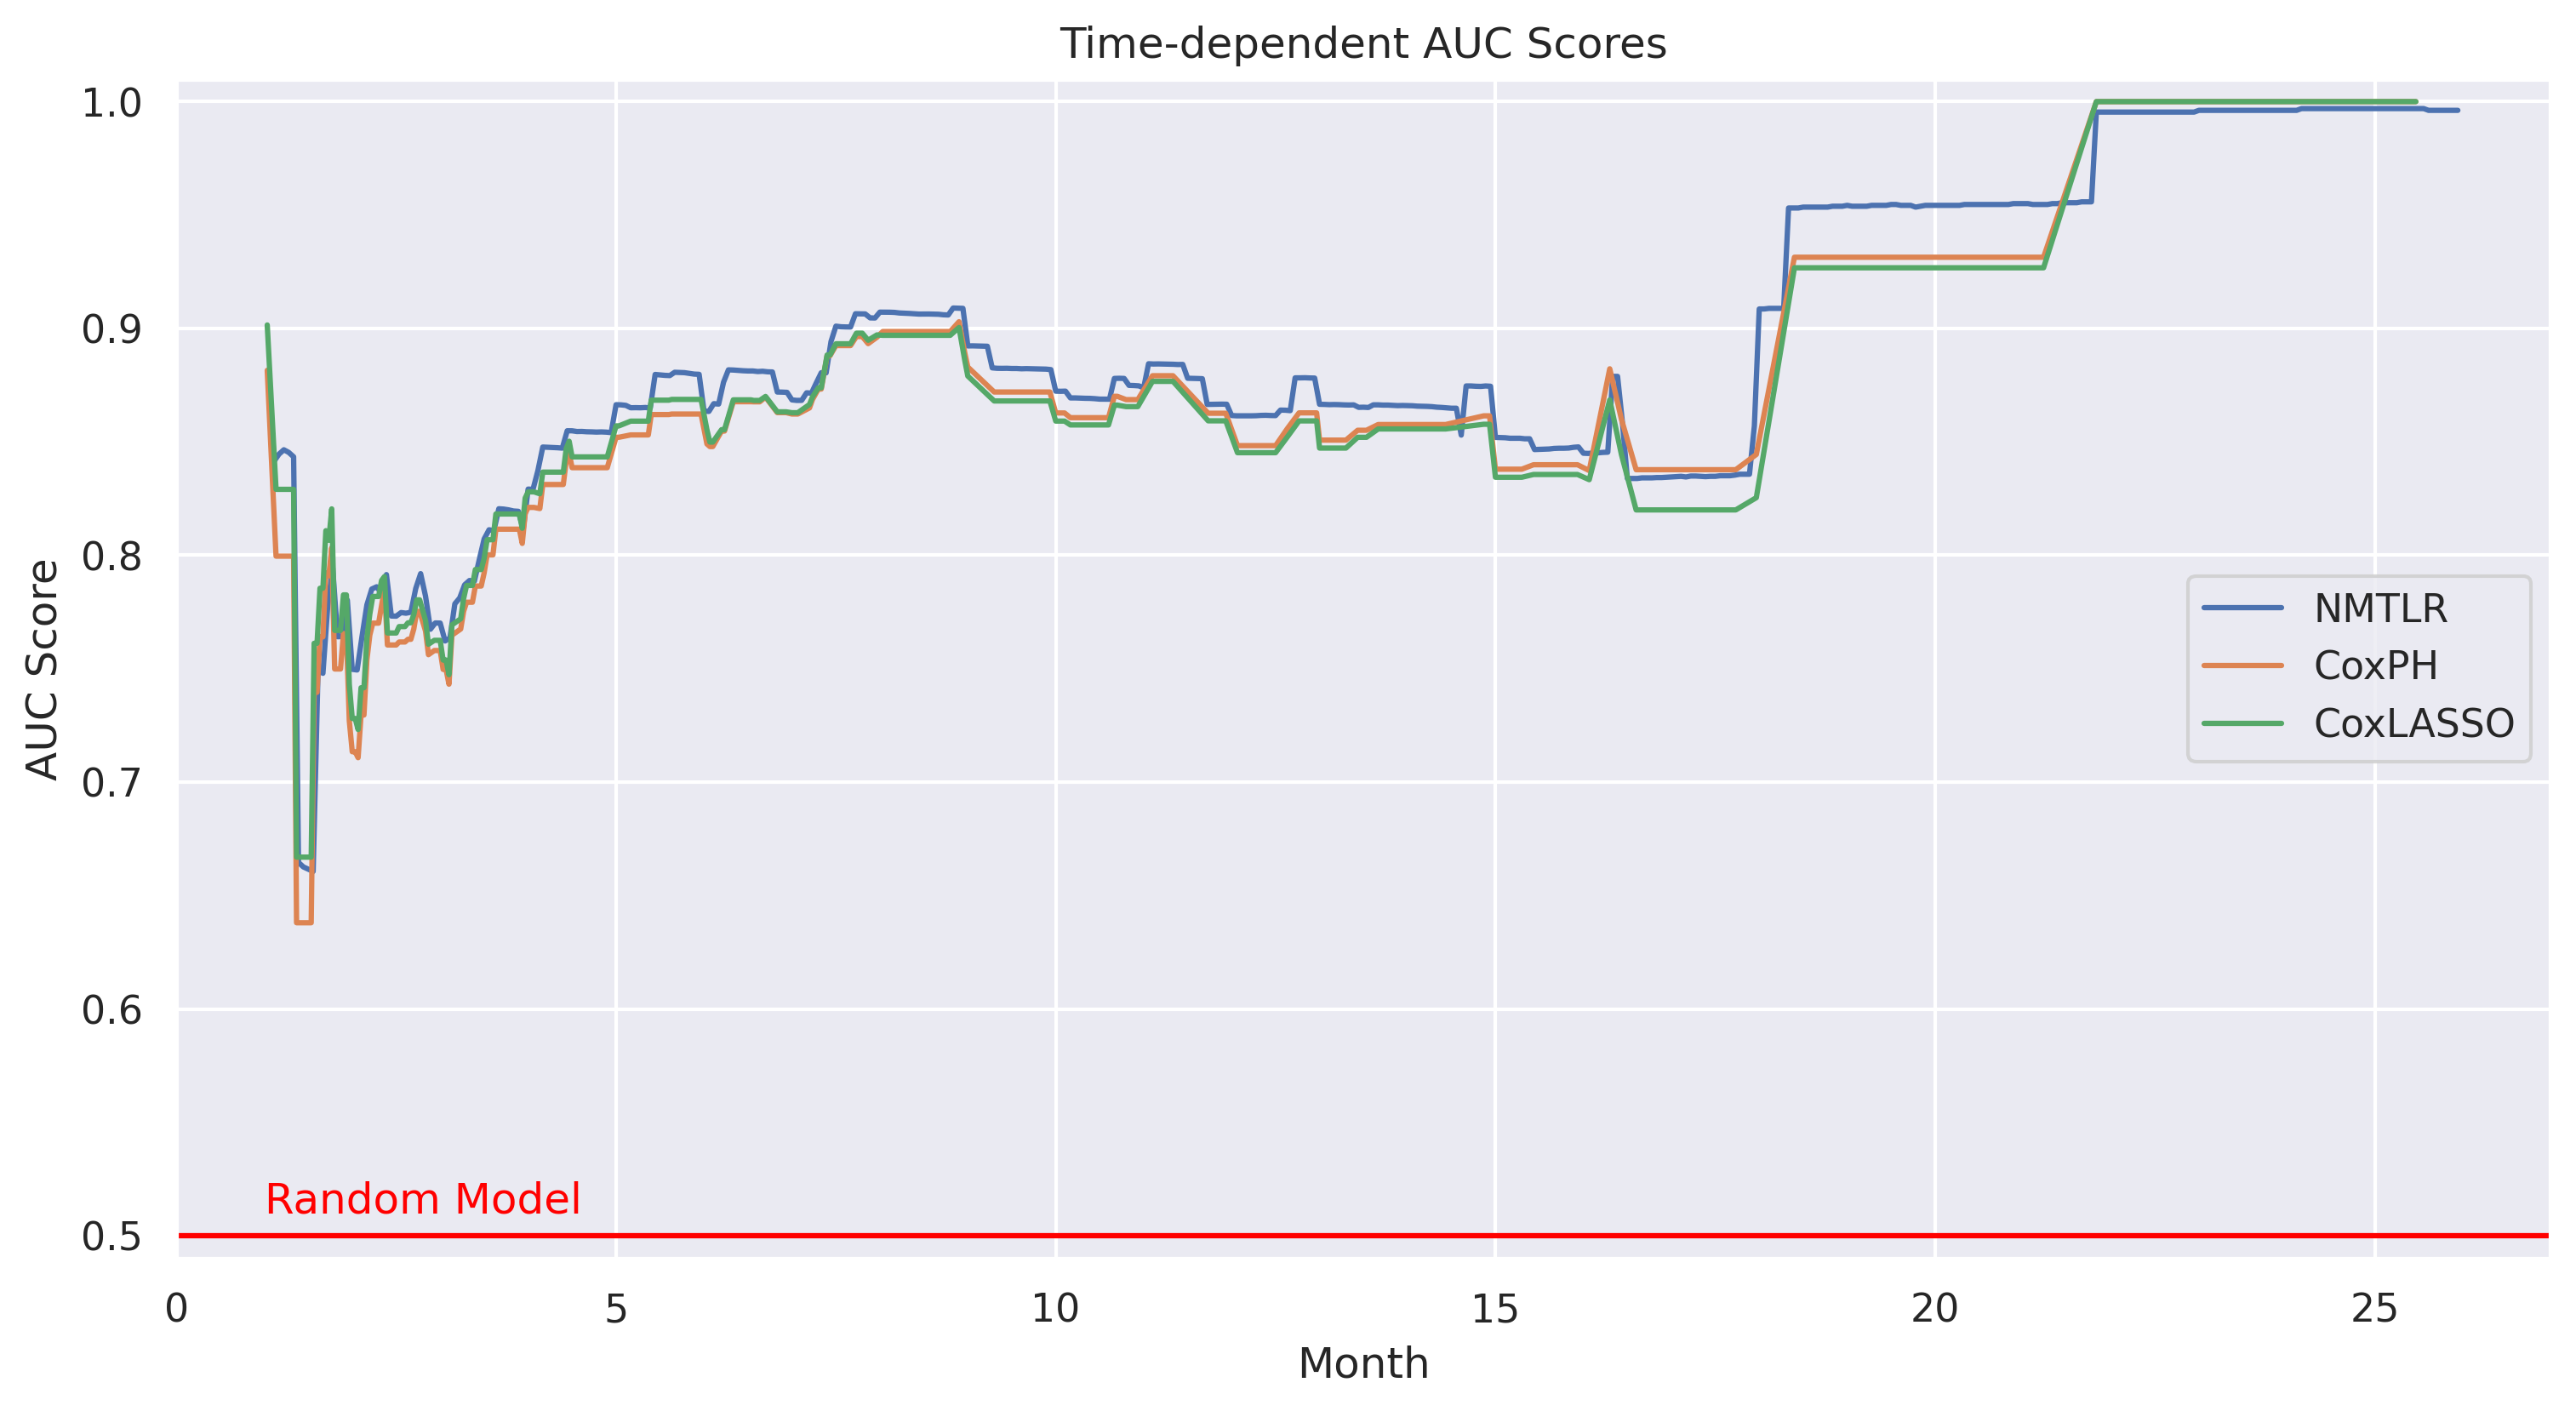

In [10]:
auc_df = pd.DataFrame([nmtlr['auc_df'], coxph['auc_df'], coxlasso['auc_df']], index=['NMTLR', 'CoxPH', 'CoxLASSO']).T

plt.figure(figsize=(12,6), dpi=300)
sns.set_theme(style='darkgrid', font='Arial')

fig = sns.lineplot(
    auc_df,
    dashes=False
)
fig.set(
    ylabel='AUC Score',
    xlabel='Month',
    title='Time-dependent AUC Scores'
)
fig.set_ylim(0.49,1.01)
fig.set_xlim(0,27)
fig.hlines(0.5, 0, 27, color='red')
fig.text(1, 0.51, 'Random Model', color='red')
sns.move_legend(fig, 'center right')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

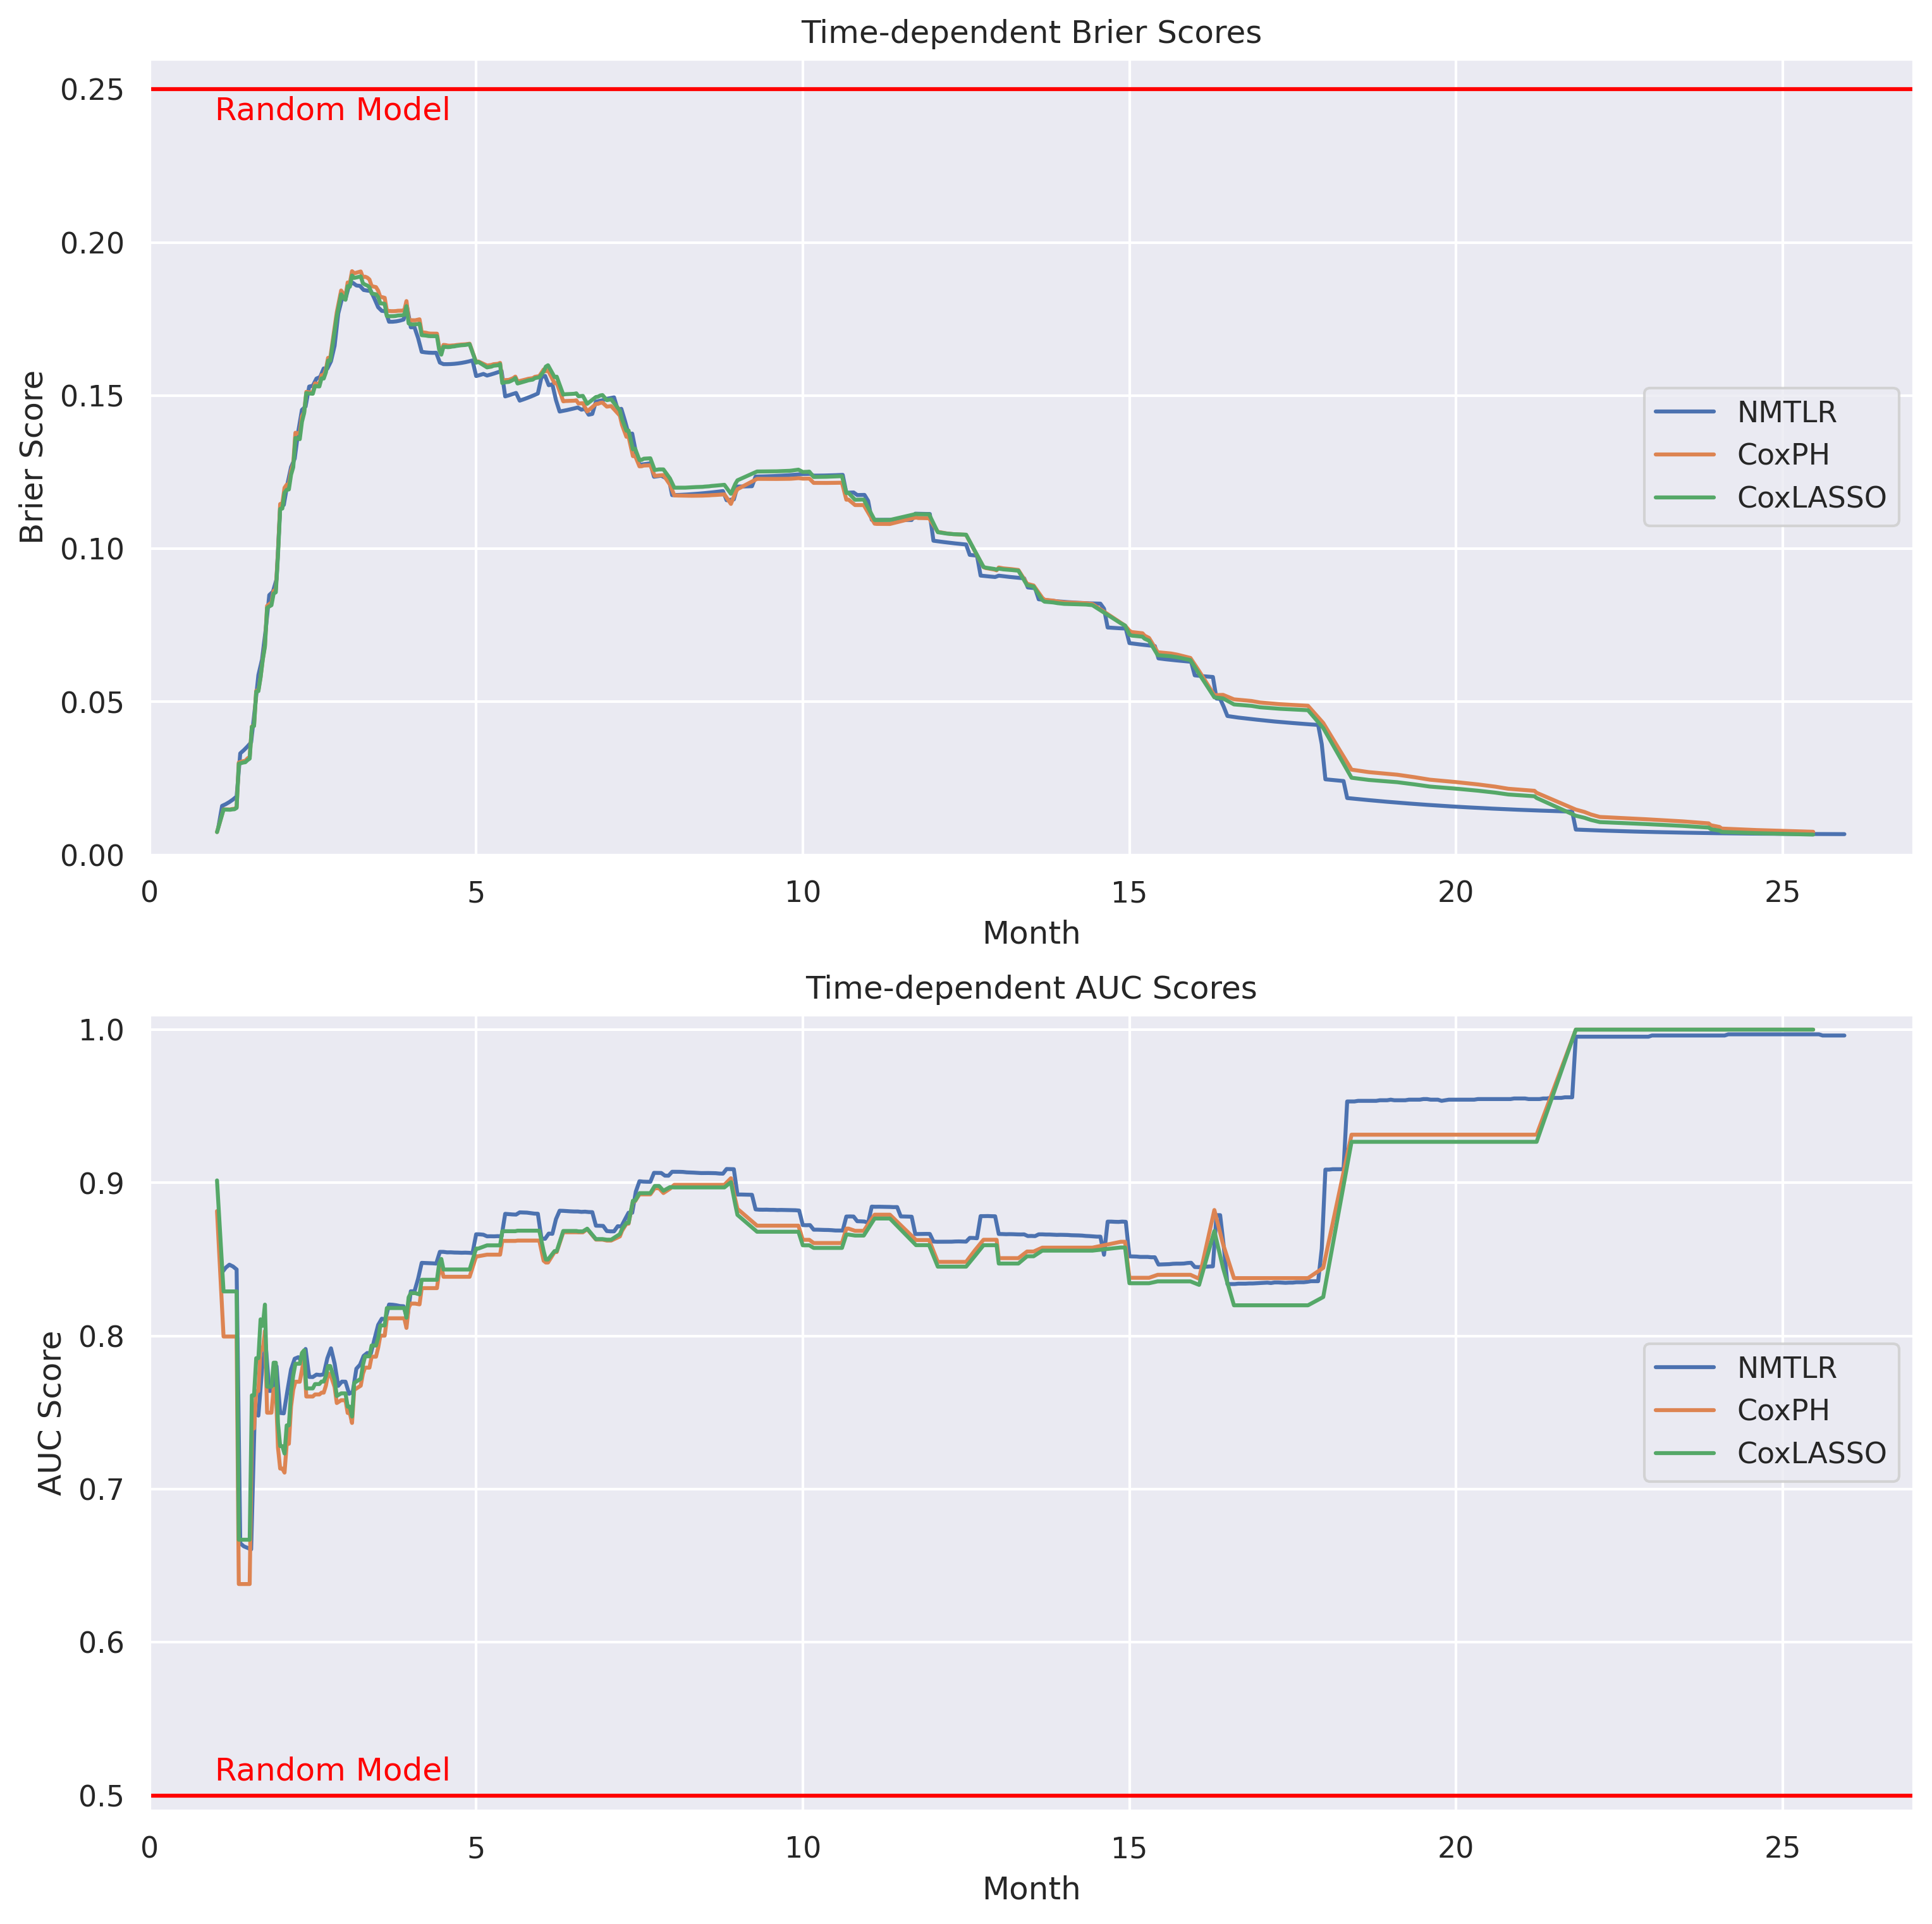

In [11]:
# Combined

fig, axes = plt.subplots(2, 1, figsize=(12,12), dpi=300)
sns.set_theme(style='darkgrid', font='Arial')

sns.lineplot(
    brier_df,
    dashes=False,
    ax=axes[0]
)
axes[0].set(
    ylabel='Brier Score',
    xlabel='Month',
    title='Time-dependent Brier Scores'
)
axes[0].set_ylim(0,0.26)
axes[0].set_xlim(0,27)
axes[0].hlines(0.25, 0, 27, color='red')
axes[0].text(1, 0.24, 'Random Model', color='red')
sns.move_legend(axes[0], 'center right')

sns.lineplot(
    auc_df,
    dashes=False,
    ax=axes[1]
)
axes[1].set(
    ylabel='AUC Score',
    xlabel='Month',
    title='Time-dependent AUC Scores'
)
axes[1].set_ylim(0.49,1.01)
axes[1].set_xlim(0,27)
axes[1].hlines(0.5, 0, 27, color='red')
axes[1].text(1, 0.51, 'Random Model', color='red')
sns.move_legend(axes[1], 'center right')